# Treasury Bond Returns Summary

In [1]:
import sys
sys.path.insert(0, "./src")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import chartbook

BASE_DIR = chartbook.env.get_project_root()
DATA_DIR = BASE_DIR / "_data"

## Data Overview

This pipeline produces Treasury bond returns data from CRSP, including:
- Individual bond returns (daily and monthly)
- Portfolio returns grouped by maturity buckets
- Treasury auction statistics
- On-the-run/off-the-run status

### Data Cleaning and Construction

The treasury bond returns dataset is constructed using the following cleaning and processing steps:

1. **Bond Selection Criteria**: Only include Treasury notes and bonds (itype 1 or 2)

2. **Return Processing**: Monthly returns are computed by compounding daily returns

3. **Maturity Grouping**:
   - Create 10 maturity groups using 0.5-year intervals from 0 to 5 years
   - Bins: [0.0, 0.5, 1.0, ..., 5.0]
   - Each group represents a specific maturity range for analysis

4. **Portfolio Construction**:
   - Group bonds by date and maturity group
   - Calculate mean returns for each group
   - This creates a time series of portfolio returns for each maturity group

## Individual Bond Returns

In [2]:
df_bonds = pd.read_parquet(DATA_DIR / "ftsfr_treas_bond_returns.parquet")
print(f"Shape: {df_bonds.shape}")
print(f"Columns: {df_bonds.columns.tolist()}")
print(f"\nDate range: {df_bonds['ds'].min()} to {df_bonds['ds'].max()}")
print(f"Number of unique bonds: {df_bonds['unique_id'].nunique()}")

Shape: (121827, 3)
Columns: ['unique_id', 'ds', 'y']

Date range: 1970-01-31 00:00:00 to 2025-08-31 00:00:00
Number of unique bonds: 2054


In [3]:
df_bonds.describe()

,unique_id,ds,y
count,121827.0,121827,121827.000000
mean,204544.45888,2004-11-11 17:16:17.901450240,0.004126
min,200636.0,1970-01-31 00:00:00,-0.151354
25%,202826.0,1992-07-31 00:00:00,-0.000881
50%,204055.0,2008-01-31 00:00:00,0.003017
75%,206660.0,2017-12-31 00:00:00,0.009241
max,208448.0,2025-08-31 00:00:00,0.175190
std,2066.352154,NaN,0.016938


## Portfolio Returns by Maturity Group

In [4]:
df_portfolio = pd.read_parquet(DATA_DIR / "ftsfr_treas_bond_portfolio_returns.parquet")
print(f"Shape: {df_portfolio.shape}")
print(f"Columns: {df_portfolio.columns.tolist()}")
print(f"\nDate range: {df_portfolio['ds'].min()} to {df_portfolio['ds'].max()}")
print(f"Maturity groups: {sorted(df_portfolio['unique_id'].unique())}")

Shape: (6659, 3)
Columns: ['unique_id', 'ds', 'y']

Date range: 1970-01-31 00:00:00 to 2025-08-31 00:00:00
Maturity groups: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:
# Summary statistics by maturity group
portfolio_stats = df_portfolio.groupby("unique_id")["y"].agg(
    ["count", "mean", "std", "min", "max"]
)
portfolio_stats.columns = ["Count", "Mean", "Std", "Min", "Max"]
portfolio_stats = portfolio_stats.sort_index(key=lambda x: x.astype(int))
portfolio_stats

,Count,Mean,Std,Min,Max
unique_id,,,,,
1,668,0.003809,0.003098,-0.000283,0.023142
2,668,0.004242,0.004619,-0.008939,0.045551
3,668,0.004447,0.006256,-0.025195,0.064735
4,665,0.004466,0.007471,-0.032362,0.068330
5,665,0.004474,0.008891,-0.046647,0.091789
6,665,0.004838,0.010458,-0.052993,0.095415
7,668,0.005006,0.011638,-0.052765,0.086319
8,668,0.005152,0.012975,-0.060457,0.093149
9,665,0.005141,0.013851,-0.058666,0.093774


## Time Series of Portfolio Returns

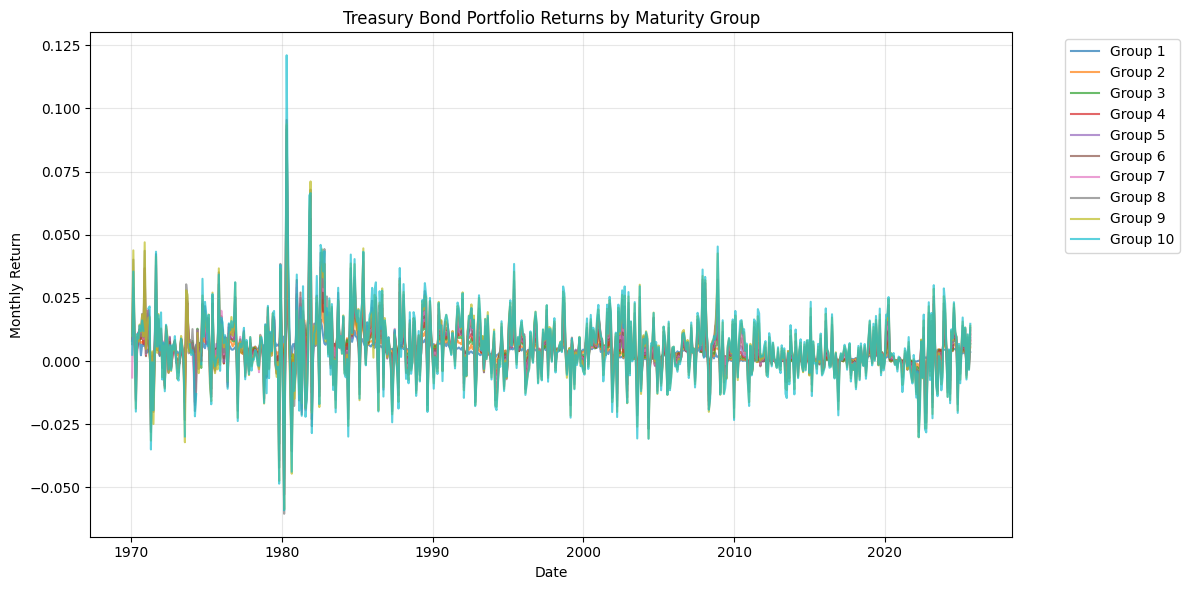

In [6]:
# Pivot for plotting
df_pivot = df_portfolio.pivot(index="ds", columns="unique_id", values="y")
df_pivot = df_pivot[sorted(df_pivot.columns, key=int)]

fig, ax = plt.subplots(figsize=(12, 6))
for col in df_pivot.columns:
    ax.plot(df_pivot.index, df_pivot[col], label=f"Group {col}", alpha=0.7)
ax.set_xlabel("Date")
ax.set_ylabel("Monthly Return")
ax.set_title("Treasury Bond Portfolio Returns by Maturity Group")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Correlation Matrix

Correlation between maturity groups shows how returns move together across the yield curve.

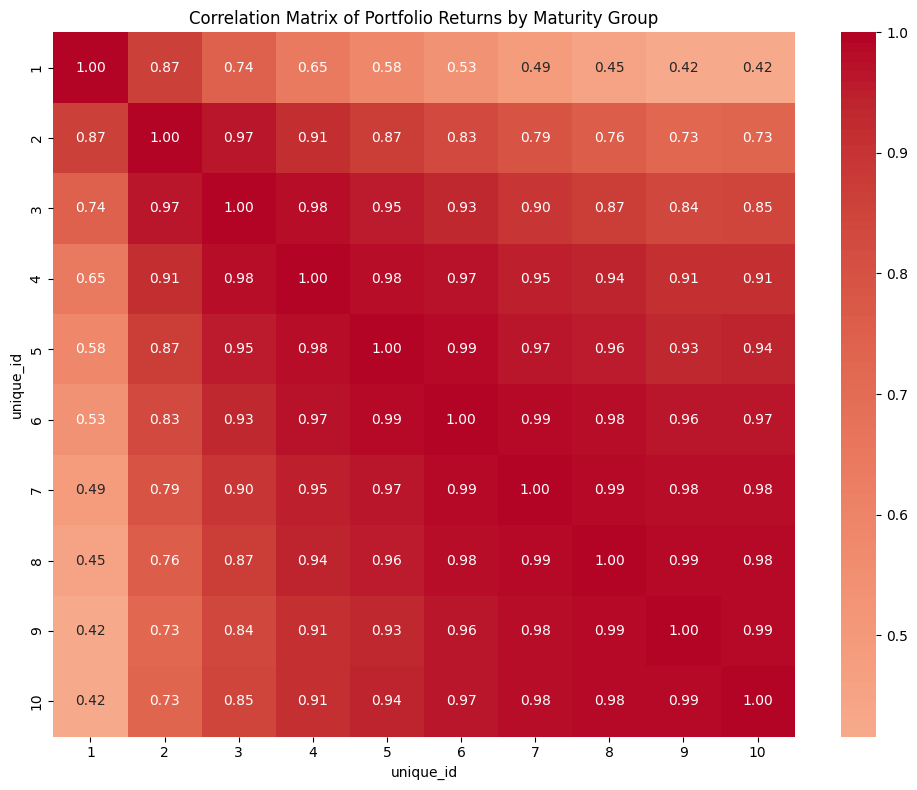

In [7]:
corr_matrix = df_pivot.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax)
ax.set_title("Correlation Matrix of Portfolio Returns by Maturity Group")
plt.tight_layout()
plt.show()

## Return Distribution by Maturity Group

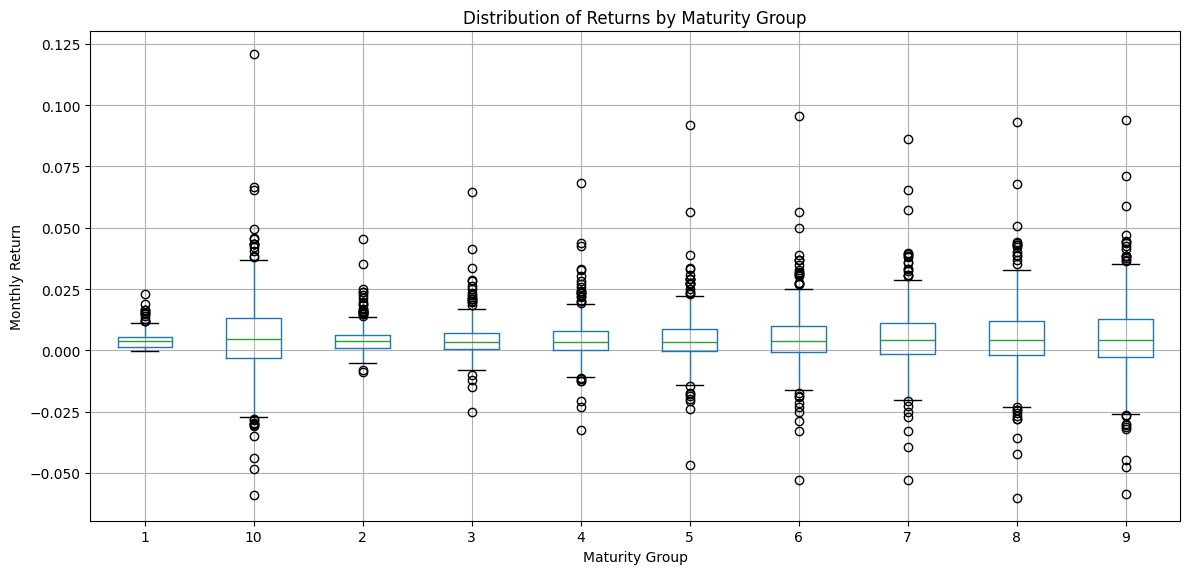

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
df_portfolio.boxplot(column="y", by="unique_id", ax=ax)
ax.set_xlabel("Maturity Group")
ax.set_ylabel("Monthly Return")
ax.set_title("Distribution of Returns by Maturity Group")
plt.suptitle("")  # Remove automatic title
plt.tight_layout()
plt.show()

## Treasury Auction Statistics

In [9]:
try:
    df_auction = pd.read_parquet(DATA_DIR / "treasury_auction_stats.parquet")
    print(f"Shape: {df_auction.shape}")
    print(f"\nSecurity types: {df_auction['securityType'].value_counts().to_dict()}")
    print(f"\nDate range: {df_auction['auctionDate'].min()} to {df_auction['auctionDate'].max()}")

    # Auction summary by type
    auction_summary = df_auction.groupby("securityType").agg({
        "totalAccepted": ["count", "mean", "sum"],
        "bidToCoverRatio": ["mean", "std"]
    }).round(2)
    print("\nAuction Summary by Security Type:")
    print(auction_summary)
except FileNotFoundError:
    print("Treasury auction stats file not found")

Shape: (10689, 120)

Security types: {'Bill': 8009, 'Note': 2253, 'Bond': 427}

Date range: 1979-10-31 00:00:00 to 2025-09-25 00:00:00

Auction Summary by Security Type:
             totalAccepted                             bidToCoverRatio      
                     count          mean           sum            mean   std
securityType                                                                
Bill                  8005  2.867568e+10  2.295488e+14            3.24  0.85
Bond                   427  1.439197e+10  6.145371e+12            2.42  0.27
Note                  2249  2.570059e+10  5.780062e+13            2.66  0.48


## Maturity Group Definitions

| Group | Maturity Range |
|-------|----------------|
| 1 | 0 to 6 months |
| 2 | 6 months to 1 year |
| 3 | 1 year to 1.5 years |
| 4 | 1.5 to 2 years |
| 5 | 2 to 2.5 years |
| 6 | 2.5 to 3 years |
| 7 | 3 to 3.5 years |
| 8 | 3.5 to 4 years |
| 9 | 4 to 4.5 years |
| 10 | 4.5 to 5 years |